### Importar bibliotecas

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configurações de visualização para os gráficos
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12

In [100]:
# Configuração para exibir todas as colunas do DataFrame
display_max_columns = None
pd.set_option('display.max_columns', display_max_columns)

### Carregar os dados

In [101]:
# Carregando o dataset
caminho_arquivo = "C:\\Users\\lfmelo\\Documents\\Github\\TJGO_CienciaDeDados\\microdados_censo_escolar_2024\\dados\\microdados_ed_basica_2024_tratado.csv"
colunas_escolhidas = ['CO_ENTIDADE', 'NO_ENTIDADE', 'NO_REGIAO', 'CO_REGIAO', 'NO_UF', 'NO_REGIAO', 'CO_UF', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO','TP_SITUACAO_FUNCIONAMENTO', 'QT_MAT_BAS', 'QT_MAT_MED', 'IN_INTERNET', 'IN_BANDA_LARGA', 'IN_INTERNET_ALUNOS', 'IN_ACESSO_INTERNET_COMPUTADOR', 'TP_REDE_LOCAL', 'IN_LABORATORIO_INFORMATICA', 'QT_DESKTOP_ALUNO', 'QT_COMP_PORTATIL_ALUNO', 'QT_TABLET_ALUNO']

try:
    df_completa = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1', low_memory=False)
    df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1', usecols=colunas_escolhidas, low_memory=False)
    print("Dados carregados com sucesso!")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho especificado. Verifique o caminho: {caminho_arquivo}")

Dados carregados com sucesso!
O dataset tem 215545 linhas e 20 colunas.


### Limpar os dados

In [102]:
colunas_qt = [col for col in df.columns if col.startswith('QT_')]
df[colunas_qt] = df[colunas_qt].fillna(0)

df_tratado = df[df['TP_SITUACAO_FUNCIONAMENTO'] == 'Em Atividade'].copy()
print(f"Número de escolas ativas: {df_tratado.shape[0]}")

Número de escolas ativas: 181065


In [103]:
df_ensino_medio = df_tratado[df_tratado['QT_MAT_MED'] > 0].copy()

print(f"Dataset filtrado para {len(df_ensino_medio)} escolas que oferecem Ensino Médio.")

Dataset filtrado para 29993 escolas que oferecem Ensino Médio.


In [104]:
# Substituir '88888.0' por np.nan
df_ensino_medio['QT_DESKTOP_ALUNO'] = df_ensino_medio['QT_DESKTOP_ALUNO'].replace(88888.0, np.nan)
df_ensino_medio['QT_COMP_PORTATIL_ALUNO'] = df_ensino_medio['QT_COMP_PORTATIL_ALUNO'].replace(88888.0, np.nan)
df_ensino_medio['QT_TABLET_ALUNO'] = df_ensino_medio['QT_TABLET_ALUNO'].replace(88888.0, np.nan)

### Tratamento dos dados

In [105]:

peso_em = 1.0
peso_outras_etapas = 1.0 # Peso para Infantil e Fundamental

qt_mat_outras_etapas = (df_ensino_medio['QT_MAT_BAS'] - df_ensino_medio['QT_MAT_MED']).clip(lower=0)

df_ensino_medio['MATRICULA_PONDERADA'] = (df_ensino_medio['QT_MAT_MED'] * peso_em) + \
                                        (qt_mat_outras_etapas * peso_outras_etapas)


cols_dispositivos = ['QT_DESKTOP_ALUNO', 'QT_COMP_PORTATIL_ALUNO', 'QT_TABLET_ALUNO']
df_ensino_medio['QT_TOTAL_DISPOSITIVOS'] = df_ensino_medio[cols_dispositivos].sum(axis=1)


numerador = df_ensino_medio['MATRICULA_PONDERADA']
denominador = df_ensino_medio['QT_TOTAL_DISPOSITIVOS']

df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] = numerador / denominador

df_ensino_medio.loc[numerador == 0, 'INDICE_PONDERADO_ALUNO_DISP'] = 0


def classificar_acesso(ratio):
    if ratio == np.inf: return 'Nenhum Dispositivo'
    if ratio > 100: return 'Crítico'
    if ratio > 50: return 'Baixo'
    if ratio > 25: return 'Adequado'
    return 'Ideal'

df_ensino_medio['INDICE_ACESSO'] = df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'].apply(classificar_acesso)


print("Amostra do DataFrame com o índice corrigido:")
display(df_ensino_medio[['NO_ENTIDADE', 'MATRICULA_PONDERADA', 'QT_TOTAL_DISPOSITIVOS', 'INDICE_PONDERADO_ALUNO_DISP', 'INDICE_ACESSO']])

Amostra do DataFrame com o índice corrigido:


,NO_ENTIDADE,MATRICULA_PONDERADA,QT_TOTAL_DISPOSITIVOS,INDICE_PONDERADO_ALUNO_DISP,INDICE_ACESSO
4,EEEFM EURIDICE LOPES PEDROSO,598.0,19.0,31.473684,Adequado
6,EEEMTI JUSCELINO KUBITSCHEK DE OLIVEIRA,367.0,25.0,14.680000,Ideal
13,COLEGIO TIRADENTES DA POLICIA MILITAR - CTPM XI,740.0,28.0,26.428571,Adequado
15,EIEEFM KON KOATT TUPARI,68.0,0.0,inf,Nenhum Dispositivo
17,EIEEFM BOATT GERAINNY,84.0,0.0,inf,Nenhum Dispositivo
...,...,...,...,...,...
215520,CED 01 DO RIACHO FUNDO II,964.0,5.0,192.800000,Crítico
215529,CED 310 DE SANTA MARIA,929.0,10.0,92.900000,Baixo
215537,COL COC BRAZLANDIA DF,243.0,12.0,20.250000,Ideal
215542,COL MAPA,373.0,22.0,16.954545,Ideal


In [106]:
df_ensino_medio[df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] < np.inf]['INDICE_PONDERADO_ALUNO_DISP'].max()

np.float64(2413.0)

In [107]:
df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'].min()

np.float64(0.022222222222222223)

### Análise Exploratória (EDA)

C:\Users\lfmelo\AppData\Local\Temp\ipykernel_12452\233171829.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


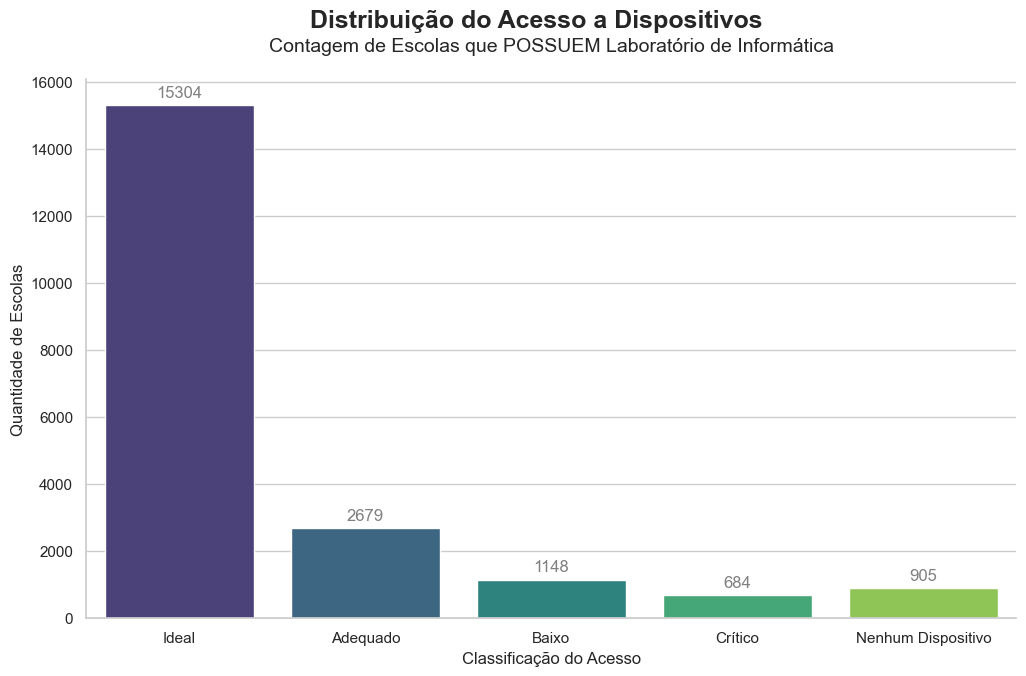

In [108]:
df_com_lab = df_ensino_medio[df_ensino_medio['IN_LABORATORIO_INFORMATICA'] == 1]

plt.figure(figsize=(12, 7))

ax = sns.countplot(
    data=df_com_lab,
    x='INDICE_ACESSO',
    order=['Ideal', 'Adequado', 'Baixo', 'Crítico', 'Nenhum Dispositivo'],
    palette='viridis'
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12,
                color='gray')

plt.suptitle('Distribuição do Acesso a Dispositivos', fontsize=18, weight='bold')
plt.title('Contagem de Escolas que POSSUEM Laboratório de Informática', fontsize=14, pad=20)
plt.xlabel('Classificação do Acesso', fontsize=12)
plt.ylabel('Quantidade de Escolas', fontsize=12)

sns.despine()

plt.show()

C:\Users\lfmelo\AppData\Local\Temp\ipykernel_12452\3049537537.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


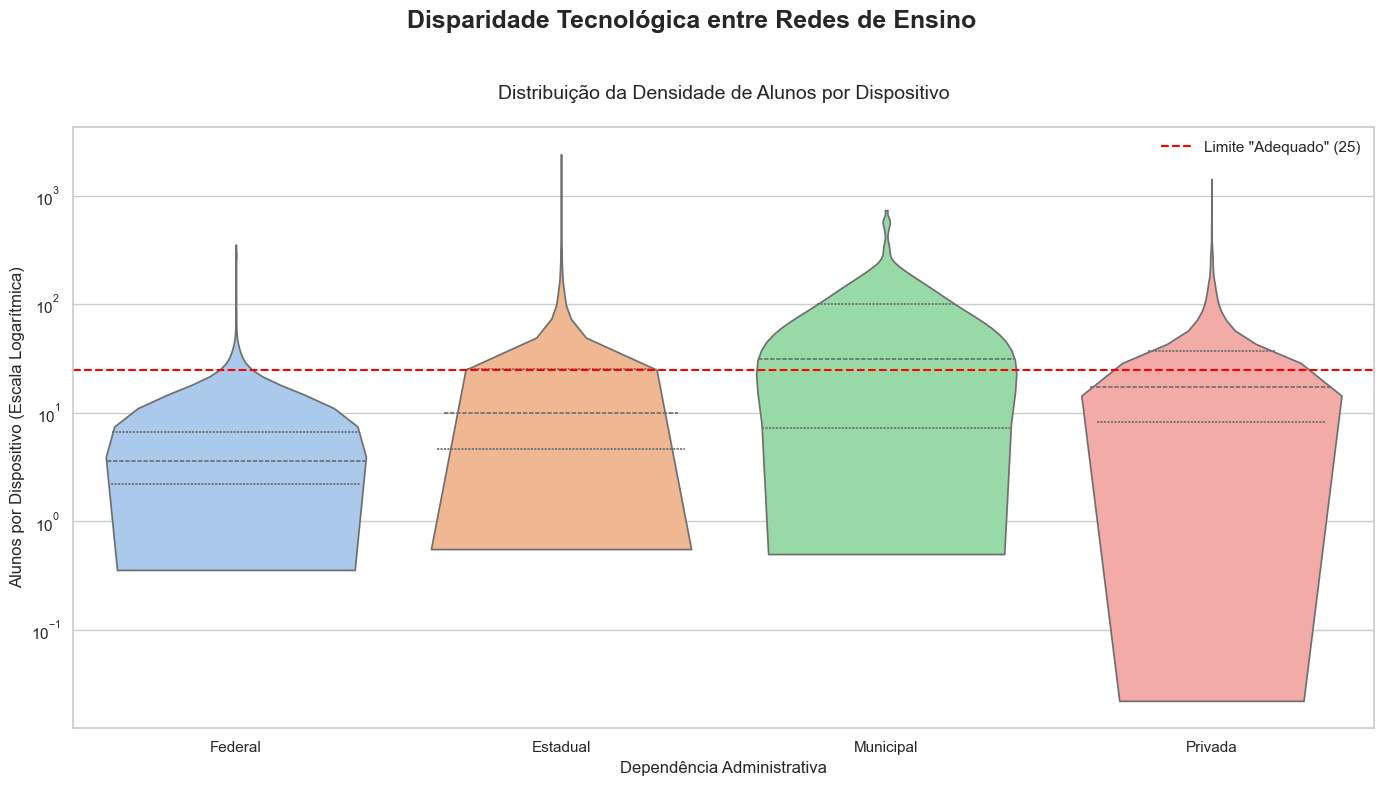

In [109]:
df_plot = df_ensino_medio[df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] != np.inf].copy()
ordem_completa = ['Federal', 'Estadual', 'Municipal', 'Privada']
categorias_presentes = df_plot['TP_DEPENDENCIA'].unique()
ordem_segura = [cat for cat in ordem_completa if cat in categorias_presentes]

plt.figure(figsize=(14, 8))
ax = sns.violinplot(
    data=df_plot,
    x='TP_DEPENDENCIA',
    y='INDICE_PONDERADO_ALUNO_DISP',
    order=ordem_segura,
    palette='pastel',
    inner='quart', 
    cut=0
)

plt.suptitle('Disparidade Tecnológica entre Redes de Ensino', fontsize=18, weight='bold')
plt.title('Distribuição da Densidade de Alunos por Dispositivo', fontsize=14, pad=20)
plt.xlabel('Dependência Administrativa', fontsize=12)
plt.ylabel('Alunos por Dispositivo (Escala Logarítmica)', fontsize=12)

plt.axhline(y=25, color='r', linestyle='--', linewidth=1.5, label='Limite "Adequado" (25)')
plt.legend()

plt.yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Gerando ranking de REGIÕES pela MEDIANA de alunos por dispositivo...


C:\Users\lfmelo\AppData\Local\Temp\ipykernel_12452\2649162879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mediana_por_regiao.values, y=mediana_por_regiao.index, palette="viridis")


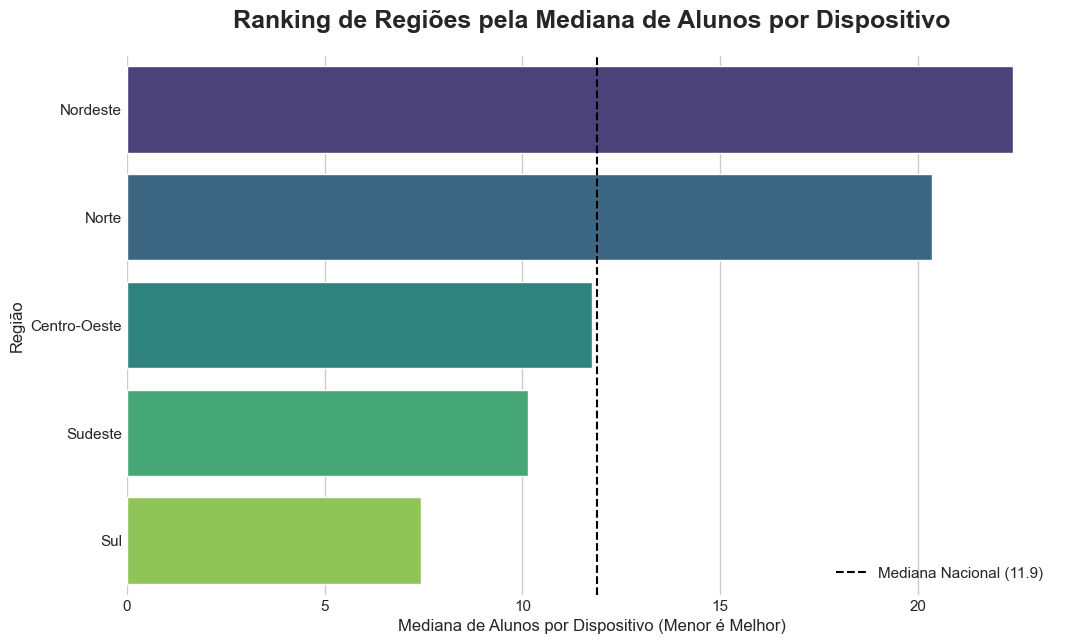

In [110]:
# 1. Preparação dos dados
print("Gerando ranking de REGIÕES pela MEDIANA de alunos por dispositivo...")
df_regiao = df_ensino_medio[df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] != np.inf].copy()

# 2. MUDANÇA PRINCIPAL: Agrupar por 'NO_REGIAO' e usar .median()
mediana_por_regiao = df_regiao.groupby('NO_REGIAO')['INDICE_PONDERADO_ALUNO_DISP'].median().sort_values(ascending=False)

# 3. A mediana nacional continua sendo a mesma referência útil
mediana_nacional = df_regiao['INDICE_PONDERADO_ALUNO_DISP'].median()


# 4. Criação do Gráfico
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7)) # Ajuste do tamanho para menos barras

ax = sns.barplot(x=mediana_por_regiao.values, y=mediana_por_regiao.index, palette="viridis")

# 5. Adicionar a linha vertical com a mediana nacional
ax.axvline(x=mediana_nacional, color='black', linestyle='--', linewidth=1.5, label=f'Mediana Nacional ({mediana_nacional:.1f})')
ax.legend()

# 6. Títulos e rótulos atualizados para 'Região'
plt.title('Ranking de Regiões pela Mediana de Alunos por Dispositivo', fontsize=18, weight='bold', pad=20)
plt.xlabel('Mediana de Alunos por Dispositivo (Menor é Melhor)', fontsize=12)
plt.ylabel('Região', fontsize=12)

sns.despine(left=True, bottom=True)
plt.show()


### Clusterização

DataFrame criado com 26945 escolas.


,CO_ENTIDADE,NO_ENTIDADE,NO_REGIAO,CO_REGIAO,NO_UF,CO_UF,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_SITUACAO_FUNCIONAMENTO,QT_MAT_BAS,QT_MAT_MED,IN_INTERNET,IN_BANDA_LARGA,IN_INTERNET_ALUNOS,IN_ACESSO_INTERNET_COMPUTADOR,TP_REDE_LOCAL,IN_LABORATORIO_INFORMATICA,QT_DESKTOP_ALUNO,QT_COMP_PORTATIL_ALUNO,QT_TABLET_ALUNO,MATRICULA_PONDERADA,QT_TOTAL_DISPOSITIVOS,INDICE_PONDERADO_ALUNO_DISP,INDICE_ACESSO,ALUNOS_POR_DISPOSITIVO,CLUSTER
4,11024682,EEEFM EURIDICE LOPES PEDROSO,Norte,1,Rondônia,11,Estadual,Urbana,Em Atividade,598.0,361.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,19.0,0.0,0.0,598.0,19.0,31.473684,Adequado,31.473684,0
6,11024968,EEEMTI JUSCELINO KUBITSCHEK DE OLIVEIRA,Norte,1,Rondônia,11,Estadual,Urbana,Em Atividade,367.0,250.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,25.0,0.0,0.0,367.0,25.0,14.680000,Ideal,14.680000,0
13,11025638,COLEGIO TIRADENTES DA POLICIA MILITAR - CTPM XI,Norte,1,Rondônia,11,Estadual,Urbana,Em Atividade,740.0,322.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,26.0,0.0,2.0,740.0,28.0,26.428571,Adequado,26.428571,0
35,11006773,EEEFM CORA CORALINA,Norte,1,Rondônia,11,Estadual,Urbana,Em Atividade,1457.0,628.0,1.0,0.0,1.0,1.0,A cabo e sem fio (wireless),1.0,25.0,21.0,0.0,1457.0,46.0,31.673913,Adequado,31.673913,0
38,11006889,EEEFM ANISIO TEIXEIRA,Norte,1,Rondônia,11,Estadual,Urbana,Em Atividade,1365.0,787.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,21.0,0.0,0.0,1365.0,21.0,65.000000,Baixo,65.000000,0



Features preparadas para o modelo:


,QT_MAT_BAS,ALUNOS_POR_DISPOSITIVO,TP_DEPENDENCIA_Estadual,TP_DEPENDENCIA_Federal,TP_DEPENDENCIA_Municipal,TP_DEPENDENCIA_Privada,NO_REGIAO_Centro-Oeste,NO_REGIAO_Nordeste,NO_REGIAO_Norte,NO_REGIAO_Sudeste,NO_REGIAO_Sul,TP_LOCALIZACAO_Rural,TP_LOCALIZACAO_Urbana
4,598.0,31.473684,True,False,False,False,False,False,True,False,False,False,True
6,367.0,14.680000,True,False,False,False,False,False,True,False,False,False,True
13,740.0,26.428571,True,False,False,False,False,False,True,False,False,False,True
35,1457.0,31.673913,True,False,False,False,False,False,True,False,False,False,True
38,1365.0,65.000000,True,False,False,False,False,False,True,False,False,False,True


Normalizando os dados...
Calculando o número ideal de clusters com o Método do Cotovelo...


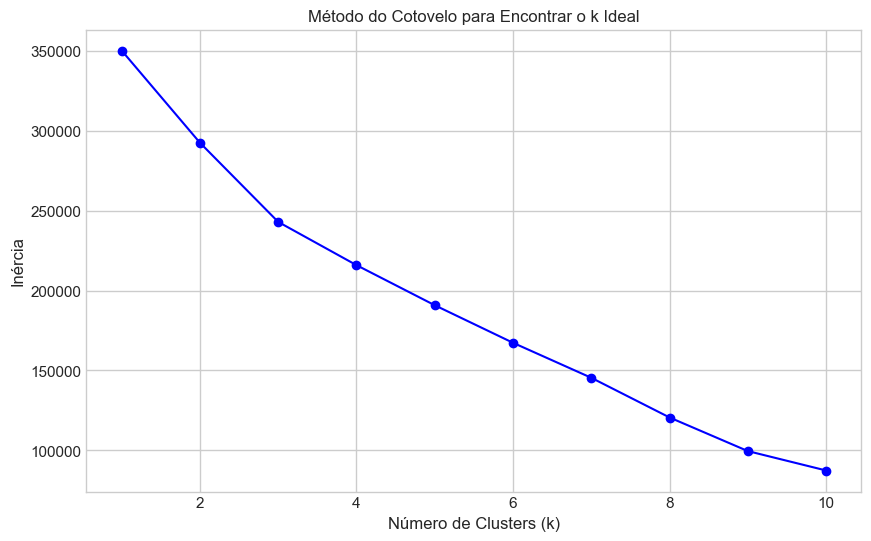


Treinando o modelo K-Means com k=4...
Clusterização completa!

Pontuação Média de Silhueta para k=4: 0.3229

--- Análise dos Perfis de Cada Cluster ---


,QT_MAT_BAS,ALUNOS_POR_DISPOSITIVO,TP_DEPENDENCIA,NO_REGIAO,TP_LOCALIZACAO
CLUSTER,,,,,
0,616.12,32.08,Estadual,Sudeste,Urbana
1,232.58,33.82,Estadual,Nordeste,Rural
2,516.63,40.72,Privada,Sudeste,Urbana
3,582.13,9.25,Federal,Nordeste,Urbana



Visualizando os clusters em 2D com PCA...


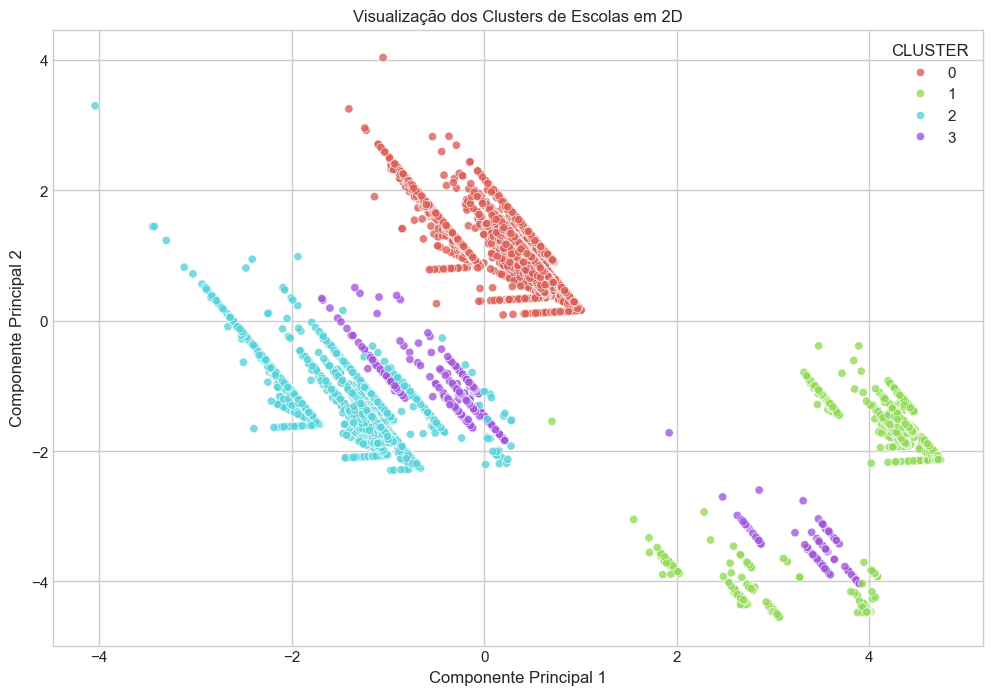

In [112]:
numerador = df_ensino_medio['QT_MAT_BAS']
denominador = df_ensino_medio['QT_TOTAL_DISPOSITIVOS']
df_ensino_medio['ALUNOS_POR_DISPOSITIVO'] = numerador / denominador
df_ensino_medio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_ensino_medio.dropna(inplace=True)

print("DataFrame criado com", len(df_ensino_medio), "escolas.")
display(df_ensino_medio.head())


features_para_cluster = [
    'QT_MAT_BAS',
    'ALUNOS_POR_DISPOSITIVO',
    'TP_DEPENDENCIA',
    'NO_REGIAO',
    'TP_LOCALIZACAO'
]

df_cluster = df_ensino_medio[features_para_cluster].copy()

df_cluster_encoded = pd.get_dummies(df_cluster, columns=['TP_DEPENDENCIA', 'NO_REGIAO', 'TP_LOCALIZACAO'])

print("\nFeatures preparadas para o modelo:")
display(df_cluster_encoded.head())


# --- Passo 3: Normalização dos Dados ---
print("Normalizando os dados...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)


print("Calculando o número ideal de clusters com o Método do Cotovelo...")
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Encontrar o k Ideal')
plt.show()

k_ideal = 4

print(f"\nTreinando o modelo K-Means com k={k_ideal}...")
kmeans = KMeans(n_clusters=k_ideal, random_state=42, n_init=10)
kmeans.fit(X_scaled)

df_ensino_medio['CLUSTER'] = kmeans.labels_
print("Clusterização completa!")

final_silhouette_score = silhouette_score(X_scaled, kmeans.labels_)
print(f"\nPontuação Média de Silhueta para k={k_ideal}: {final_silhouette_score:.4f}")

print("\n--- Análise dos Perfis de Cada Cluster ---")
analise_numerica = df_ensino_medio.groupby('CLUSTER')[['QT_MAT_BAS', 'ALUNOS_POR_DISPOSITIVO']].mean().round(2)
analise_categorica = df_ensino_medio.groupby('CLUSTER')[['TP_DEPENDENCIA', 'NO_REGIAO', 'TP_LOCALIZACAO']].agg(lambda x: x.mode()[0])
perfis_clusters = pd.concat([analise_numerica, analise_categorica], axis=1)

display(perfis_clusters)


print("\nVisualizando os clusters em 2D com PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
df_pca['CLUSTER'] = kmeans.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Componente Principal 1',
    y='Componente Principal 2',
    hue='CLUSTER',
    palette=sns.color_palette("hls", k_ideal),
    data=df_pca,
    legend="full",
    alpha=0.8
)
plt.title('Visualização dos Clusters de Escolas em 2D')
plt.show()